<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/Practice/LSTM_and_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Practice 1

[정텐첫] 14. LSTM을 이용한 날씨 예측, 정채나 유튜브 참고

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/LoadForecasting


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

df = pd.read_excel('jeju_asos_data_3.xlsx')
df.head()     # 상위 5개 항목 출력
#print(len(df))    # time step = 1095

,date,max,min,TIME_1,TIME_2,TIME_3,TIME_4,TIME_5,TIME_6,TIME_7,...,TIME_22,TIME_23,TIME_24,p-temp,temp,rain,humidity,solar,cloud,wind
0,2021-01-01,812,641,739,708,683,672,672,681,696,...,751,736,733,-1.4,5.5,0.0,54.4,2.55,9.3,3.8
1,2021-01-02,851,599,697,673,652,649,653,664,681,...,813,802,801,-1.2,5.9,0.0,56.4,5.45,6.8,4.3
2,2021-01-03,839,556,757,720,697,686,687,697,712,...,770,754,749,-1.5,4.5,NaN,57.0,7.85,7.8,2.5
3,2021-01-04,873,673,711,689,677,674,685,702,739,...,774,748,740,-0.9,5.9,NaN,57.8,8.38,6.0,1.7
4,2021-01-05,917,654,706,674,654,657,663,676,693,...,816,795,798,-2.6,5.6,0.0,66.0,2.77,9.5,4.0


In [ ]:
pred_date = input('예측할 날짜를 입력하시오 (YYYY-MM-DD) : ')

예측할 날짜를 입력하시오 (YYYY-MM-DD) : 2023-01-09


전력max데이터만 가지고 전력max값 예측하기

In [ ]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:

        end_idx = len(dataset) - target_size + 1

    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        label.append(dataset[i:i+target_size])
    return np.array(data), np.array(label)

In [ ]:
# train data 1000개

train_split = 730   # 학습하는데 쓰는 데이터 개수
tf.random.set_seed(13)    # 인공지능 초기화

In [ ]:
uni_data = df['max']
date = df['date']
uni_data.index = df['date']
uni_data.head()

date
2021-01-01    812
2021-01-02    851
2021-01-03    839
2021-01-04    873
2021-01-05    917
Name: max, dtype: int64

In [ ]:
def date_diff(date1, date2):
    # 두 날짜를 datetime 객체로 변환
    dt1 = datetime.strptime(date1, '%Y-%m-%d')
    dt2 = datetime.strptime(date2, '%Y-%m-%d')

    # 날짜 간의 차이 계산
    diff = dt2 - dt1

    return diff.days

date1 = str(np.array(date)[0].astype('M8[D]').astype('O'))
date2 = pred_date

date_diff = date_diff(date1, date2)
print(f"{date1}부터 {date2}까지의 날짜 차이: {date_diff}일")


2021-01-01부터 2023-01-09까지의 날짜 차이: 738일


array([<Axes: xlabel='date'>], dtype=object)

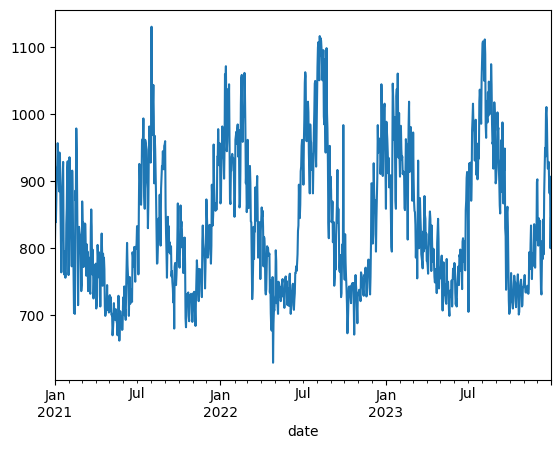

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
max_data = uni_data.values
# print(max_data)
# print(np.size(max_data))
# print(max_data[:train_split])

In [ ]:
# 데이터 표준화 (측정치-평균값) / 표준편차

uni_train_mean = max_data[:train_split].mean()
print(uni_train_mean)
uni_train_std = max_data[:train_split].std()
print(uni_train_std)
max_data = (max_data - uni_train_mean) / uni_train_std
print(max_data)

830.5958904109589
103.16342791815134
[-0.18025662  0.19778433  0.08146404 ...  0.74061236 -0.29657691
  0.13962419]


In [ ]:
x_train_uni, y_train_uni = univariate_data(max_data, 0, train_split, 10, 1)
x_val_uni, y_val_uni = univariate_data(max_data, train_split, None, 10, 1)

print(x_train_uni[0])
print(y_train_uni[0])

[[-0.18025662]
 [ 0.19778433]
 [ 0.08146404]
 [ 0.4110382 ]
 [ 0.83754593]
 [ 0.90539944]
 [ 1.22528024]
 [ 1.0507998 ]
 [ 0.730919  ]
 [ 0.52735849]]
[1.08957323]


In [ ]:
def create_time_steps(length):
    return list(range(-length,0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i , x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize= 10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0],(future+5)*2])
    plt.xlabel('Time Steps')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

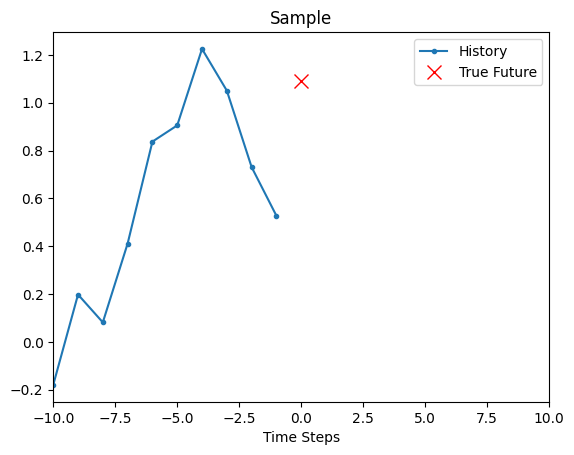

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample')

[943.]
890.3
[5.58854719]


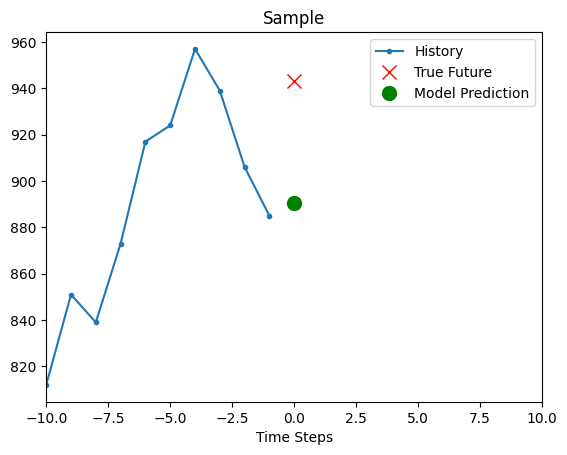

In [ ]:
# 단순 과거 데이터 평균으로 예측한 결과

def baseline(history):
    return np.mean(history)

a = uni_train_std * x_train_uni[0] + uni_train_mean
b = uni_train_std * y_train_uni[0] + uni_train_mean
c = uni_train_std * baseline(x_train_uni[0]) + uni_train_mean
show_plot([a,b,c],0, 'Sample')

print(b)
print(c)
print((b-c)/b*100)

In [ ]:
# LSTM

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(20).batch(16).repeat()

var_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
var_univariate = var_univariate.batch(1).repeat()

In [ ]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(720, 10, 1)
(720, 1)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in train_univariate.take(1):
  print(model.predict(x).shape)

1/1 [==============================] - 0s 495ms/step
(16, 1)


In [ ]:
model.fit(train_univariate, epochs=10, steps_per_epoch=200, validation_data = var_univariate,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 9ms/step - loss: 0.5162 - val_loss: 0.4816
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3725 - val_loss: 0.4957
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3532 - val_loss: 0.4868
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3390 - val_loss: 0.4738
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.3335 - val_loss: 0.4617
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3199 - val_loss: 0.4397
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3109 - val_loss: 0.4238
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2961 - val_loss: 0.4087
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2942 - val_loss: 0.4075
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2927 - val_loss: 0.4

1/1 [==============================] - 0s 21ms/step
[[859.]
 [989.]
 [976.]
 [963.]
 [943.]
 [912.]
 [935.]
 [891.]
 [908.]
 [902.]]


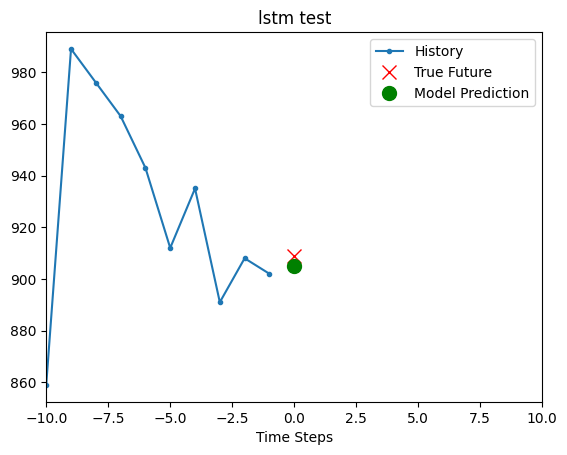

[909.]
[905.1084]
[0.42811898]
1/1 [==============================] - 0s 26ms/step
[[989.]
 [976.]
 [963.]
 [943.]
 [912.]
 [935.]
 [891.]
 [908.]
 [902.]
 [909.]]


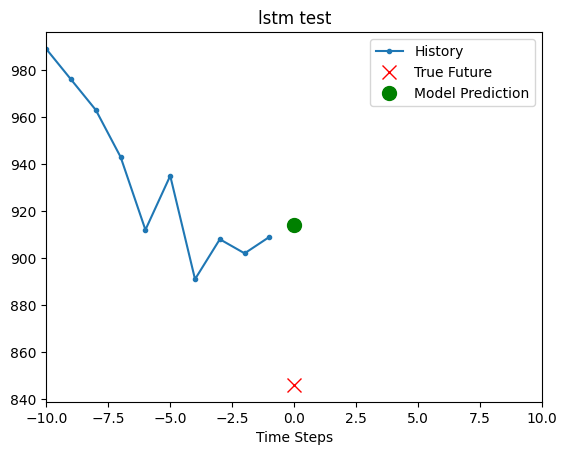

[846.]
[914.1642]
[-8.05723222]
1/1 [==============================] - 0s 22ms/step
[[976.]
 [963.]
 [943.]
 [912.]
 [935.]
 [891.]
 [908.]
 [902.]
 [909.]
 [846.]]


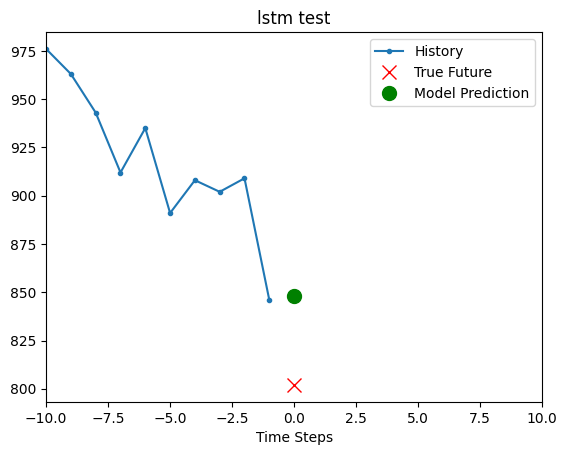

[802.]
[848.15]
[-5.75436713]


In [ ]:
for x,y in var_univariate.take(3):

    a = uni_train_std * x[0].numpy() + uni_train_mean
    b = uni_train_std * y[0].numpy() + uni_train_mean
    c = uni_train_std * model.predict(x)[0] + uni_train_mean
    print(a)
    plot=show_plot([a,b,c],0,'lstm test')
    plot.show()

    print(b)
    print(c)
    print((b-c)/b*100)

LSTM 학습 결과 처음보다 오차가 줄었음을 확인할 수 있었음.

여러 외생변수를 이용하여 임의 시각의 전력 예측

In [ ]:
feature_con =['TIME_19','p-temp','humidity','solar','cloud'] # 최대, 체감온도
df = df.fillna(0)
feature = df[feature_con]
#feature.index = df['Date Time']
feature.head()

,TIME_19,p-temp,humidity,solar,cloud
0,812,-1.4,54.4,2.55,9.3
1,851,-1.2,56.4,5.45,6.8
2,839,-1.5,57.0,7.85,7.8
3,863,-0.9,57.8,8.38,6.0
4,906,-2.6,66.0,2.77,9.5


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

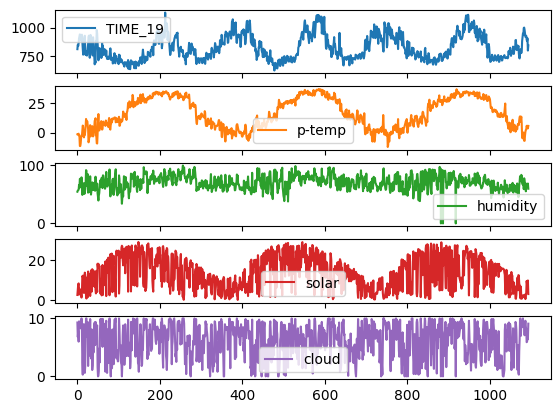

In [ ]:
feature.plot(subplots=True)

In [ ]:
dataset = feature.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
print(data_mean)
print(data_std)
dataset = (dataset-data_mean) / data_std

[819.20273973  16.33876712  70.89958904  13.97438356   6.13986301]
[107.62889052  12.63040975  11.69770788   8.12715824   2.81128596]


In [ ]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i+1, step)
        new_dataset=dataset[indices]
        new_dataset[-1][0] = 0    # 예측하는 날짜의 전력데이터 영향x
        data.append(new_dataset)

        if single_step:
            label.append(target[i+target_size])
        else:
            label.append(target[i:i+target_size])

    return np.array(data), np.array(label)

In [ ]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, train_split, 20, 1, 1, single_step = True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], train_split, None, 20, 1, 1, single_step = True)

In [ ]:
print(x_train_single[0].shape)

(21, 5)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(20).batch(64).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(2).repeat()

In [ ]:
single_model = tf.keras.models.Sequential()
single_model.add(tf.keras.layers.GRU(32,input_shape=x_train_single.shape[-2:], return_sequences=True))
single_model.add(tf.keras.layers.Activation('gelu'))
single_model.add(tf.keras.layers.GRU(32, return_sequences=True))
single_model.add(tf.keras.layers.Activation('gelu'))
single_model.add(tf.keras.layers.GRU(32))
single_model.add(tf.keras.layers.Dense(1))
single_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
# model.compile(optimizer='adam', loss='mae')

In [ ]:
single_history = single_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 16s 46ms/step - loss: 0.3016 - val_loss: 0.1889
Epoch 2/10
200/200 [==============================] - 8s 38ms/step - loss: 0.2151 - val_loss: 0.2936
Epoch 3/10
200/200 [==============================] - 9s 46ms/step - loss: 0.1952 - val_loss: 0.2666
Epoch 4/10
200/200 [==============================] - 7s 36ms/step - loss: 0.1803 - val_loss: 0.2824
Epoch 5/10
200/200 [==============================] - 9s 45ms/step - loss: 0.1700 - val_loss: 0.4348
Epoch 6/10
200/200 [==============================] - 7s 34ms/step - loss: 0.1589 - val_loss: 0.3598
Epoch 7/10
200/200 [==============================] - 9s 44ms/step - loss: 0.1492 - val_loss: 0.3603
Epoch 8/10
200/200 [==============================] - 7s 36ms/step - loss: 0.1406 - val_loss: 0.6010
Epoch 9/10
200/200 [==============================] - 9s 46ms/step - loss: 0.1265 - val_loss: 0.6147
Epoch 10/10
200/200 [==============================] - 7s 34ms/step - loss: 0.1104 - val_l

1/1 [==============================] - 2s 2s/step


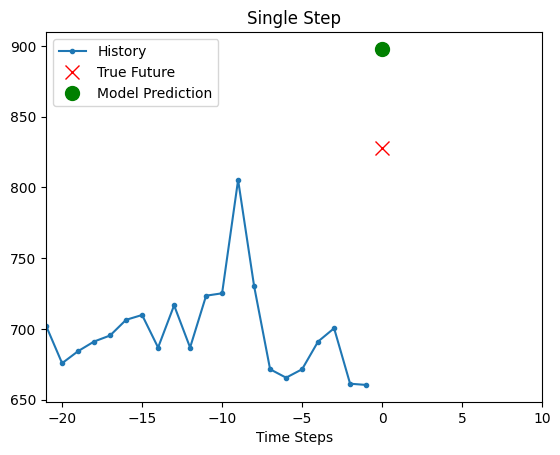

828.0
[897.844]
[-8.435265]
1/1 [==============================] - 0s 40ms/step


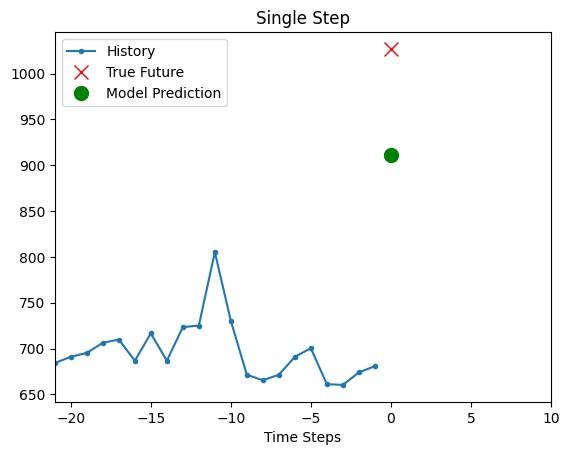

1027.0
[911.71674]
[11.225245]
1/1 [==============================] - 0s 41ms/step


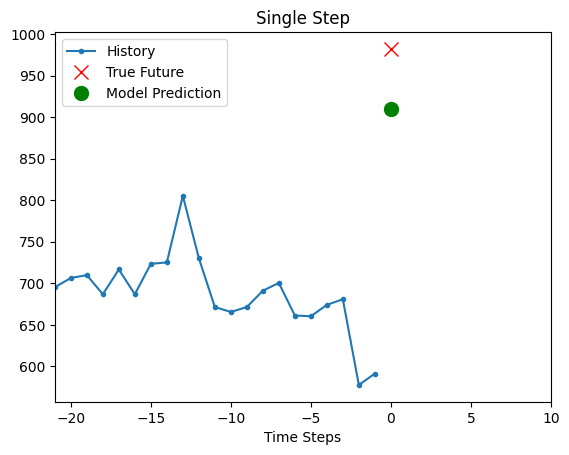

982.0
[909.39014]
[7.3940797]


In [ ]:
for x, y in val_data_single.take(3):
    a = data_std[0] * x[0][:,1].numpy() + data_mean[0]
    b = data_std[0] * y[0].numpy() + data_mean[0]
    c = data_std[0] * single_model.predict(x)[0] + data_mean[0]
    plot = show_plot([a, b, c],0,'Single Step')
    plot.show()

    print(b)
    print(c)
    print((b-c)/b*100)